<left><img width=100% height=100% src="img/itu_logo.png"></left>

## Lecture 11: Decision Trees for Classification

### __Gül İnan__<br><br>Istanbul Technical University

## Heart Disease Dataset

The heart disease dataset (available [here](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) contains the records of patients who presented with chest pain and was subsequently diagnosed with having (Yes) or not having a heart disease (No).

The heart disease dataset contains the following columns:

- `Age`: Age in years.
- `Sex`: Sex (1 = male; 0 = female).
- `ChestPain`: Chest pain type (1 = typical, 2 = nontypical, 3 = nonanginal, 4 = asymptomatic).
- `RestBP`: Resting blood pressure (in mm  Hg on admission to the Hospital).
- `Chol`: Serum cholesterol in mg/dl.
- `Fbs`: Fasting blood sugar > 120 mg/dl (1 = True, 0 = False).
- `RestECG`: Resting electrocardiographic results (0 = normal, 1 = having ST-T wave abnormality, 2 = left ventricular hyperthrophy).
- `MaxHR`: Max heart rate achieved by an individual.
- `ExAng`: Exercise induced angina (1 = Yes, 0 = No).
- `Oldpeak`: ST depression induced by exercise relative to the rest.
- `Slope`: The slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping). 
- `Ca`: Number of major vessels (0-3) colored by fluoroscopy.
- `Thal`: Thalassemia (1 = normal, 2 = fixed defect, 3 = reversible defect).
- `AHD`: Heart disease (Yes, No).

Our aim here is that we would like to build a `classifier` to predict the `class label`, that's, whether a new patient has or does not have a heart disease based on the features given above.

Let's start by loading this dataset.

In [736]:
#import the data set

import pandas as pd

heart_df = pd.read_excel("datasets/heart.xlsx", index_col=0, header=1)

#Print a portion of the dataset
heart_df.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,2.0,No
2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,1.0,Yes
3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,3.0,Yes
4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,1.0,No
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,1.0,No


In [737]:
# Data set size
heart_df.shape

(303, 14)

In [738]:
#check the variables in the data set
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 1 to 303
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    int64  
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         299 non-null    float64
 12  Thal       301 non-null    float64
 13  AHD        303 non-null    object 
dtypes: float64(3), int64(10), object(1)
memory usage: 35.5+ KB


In [739]:
# remove missing rows
heart_df = heart_df.dropna(axis=0)

In [740]:
# Data set size
heart_df.shape

(297, 14)

In [741]:
#Check the classes and their corresponding frequencies
heart_df.AHD.value_counts()

No     160
Yes    137
Name: AHD, dtype: int64

## Decision Trees: Intuition

`Decision tree` algorithms are a _non-parametric_ supervised machine learning approach for classification as well as regression tasks. `Decision tree` algorithms aims to successively partition the (training) feature space $\mathbf{X}$ into a number of smaller regions by splitting a single feature $x_j$ at a time until a `stopping rule` is satistfied or no further desirable splitting is available. 

Let $R_1,\ldots, R_S$ be the **final partitioned regions**. `Decision tree` algorithms assign the training observations to one of these regions $R_1,\ldots, R_S$ in which they satisfy the successive splitting rule.

In order to predict the class label of a new observation ${x}_{n+1}$ , `decision tree classifiers` identify the region which the new observation belongs to, say, ${x}_{n+1} \in R_s$ and then predict the label of ${x}_{n+1}$ as the `majority vote` of class labels in that region.


$$
\hat{y}_{n+1} = \operatorname*{argmax}_{c_1,\ldots, c_K} \sum_{(\mathbf{X}_i, y_i) \in R_s} I(y_i = c_k).
$$

## Decision Trees: Motivating Example

Let’s illustrate `partition` of the feature space of heart disease data set assuming that we have only two features: $\mathbf{X}$=(`Age`, `MaxHR`) to predict the heart status of the patients and use 80% of the data ($n_{train}=237$) as training set. 

1. We first start partitioning feature space $\mathbf{X}$ by picking a feature such as `MaxHr`.
2. Then we define a **binary-split** condition on `MaxHr` such as: 

$$
MaxHr <= 147.5 \quad \text{or}  \quad MaxHr > 147.5.
$$

 - We assign patients having $MaxHr <= 147.5$ in the training data to the left branch and patients with $MaxHr > 147.5$ in the training data to the right branch.

<br>

![](img/tree1.png)

 - This splitting rule also divides the feature space $\mathbf{X}$ into two half-planes: 

   $
   R_1=\{\mathbf{X}: MaxHr \leq 147.5 \}  \quad  \text{and}  \quad \\ 
   R_2=\{\mathbf{X}: MaxHr > 147.5 \}.
   $

![](img/db1.png)

3. To `grow branches`, we then select the feature `Age` and apply the following **binary-split** rule on  $R_1$: 
   
$$
Age <= 67.5
$$

   - and another **binary-split** rule on $R_2$:

$$
Age <= 57.5.
$$

   - Hence, we grow two `branches` on the root `MaxHR` as follows:

![](img/tree2.png)


  - This binary-splitting rule further divides the feature space $\mathbf{X}$ into a total of four regions: 

  $
  R_1=\{\mathbf{X}: MaxHr \leq 147.5 \quad  \text{and} \quad  Age <= 67.5\},  \quad   \\
  R_2=\{\mathbf{X}: MaxHr \leq 147.5 \quad  \text{and} \quad  Age > 67.5\}, \quad  \\
  R_3=\{\mathbf{X}: MaxHr > 147.5 \quad  \text{and} \quad  Age <= 57.5\},   \quad  \text{and}  \quad \\ 
  R_4=\{\mathbf{X}: MaxHr > 147.5 \quad  \text{and} \quad  Age > 57.5\}.
  $

![](img/db2.png)

## Tree Terminologies

- Since the set of binary splitting rules used to successively partition the feature space can be summarized in a tree, as can be seen above, these type of approaches are called as `decision tree` methods.

- In a typical representation of decision trees, the most commonly used terminologies are:

   - A `root node`: represents the first condition to check. In the figure above, the root node is indicated by the condition $MaxHr <= 147.5$.
   - An `internal (decision) node`: represents any conditions within the tree. In the figure above, two internal nodes are indicated by the conditions $Age <= 67.5 $ and $Age <= 57.5$.
   - An `edge`: The path (line segment) between two consecutive nodes.
   - A `leaf (terminal) node `: represents the predicted class/value.
   - `Tree depth`: The number of edges on the path from the root node to the farthest away leaf (terminal ) node.

  ![](img/tree_structure.png)

## Node Impurity


In decision trees, we need alternative metrics which measure the `quality of split`. 

Let's define the proportion of training observations in the $s$th region, $R_s$,
that are from the $k$th class as:

$$
\hat{p}_{sk} = \frac{1}{|R_s|}\sum_{(\mathbf{X}_i, y_i) \in R_s} I(y_i = c_k),
$$

where $s=1, \ldots, S$ and $k=1, \ldots, K$, where $S$ is the total number of final regions and $K$ is the total number of class labels.

The `Gini index` of region $R_s$  is defined as:


$$
GI(R_s) = \sum_{k=1}^{K} \hat{p}_{sk}(1-\hat{p}_{sk}),
$$

where $s=1, \ldots, S$ and $k=1, \ldots, K$. The `Gini index` is a measure of total variance across $K$ classes. The Gini index takes on
a small value if all of the $p_{sk}$'s are close to zero or one. 

For this reason, the Gini index is referred to as a measure of `node impurity`- **a small value** indicates that a node contains predominantly training
**observations from a single class**.


![](img/gini_treee.png)

An alternative to the Gini index is `cross-entropy`.  The `cross-entropy` of region $R_s$  is defined as:

$$
CE(R_s) = -\sum_{k=1}^{K} \hat{p}_{sk} \log(\hat{p}_{sk}),
$$

where $s=1, \ldots, S$ and $k=1, \ldots, K$. Since  $0 < \hat{p}_{sk} <1$, it follows that $0 < -\hat{p}_{sk} \log(\hat{p}_{sk})$. One can show that the entropy will take on a value near zero if the  $p_{sk}$'s are all near zero or near one. Therefore, like Gini index, the entropy will take on a small value if the $s$th region is pure. 


![](img/gini_tree2.png)




In fact, it turns out that the Gini index and the entropy are quite similar numerically.

When building a classification tree, either Gini index or the entropy are typically used to evaluate the quality of a particular split, since these two approaches are more sensitive to node purity.

## Learning in Decision Trees

The decision tree algorithms primarily learn two things:

- The `feature` that will be split at the first partition, the second partition and so on.

- The `threshold value` to split a specific feature.

One approach would be to try all possible feature and threshold combinations that will constitute the final partitioned regions $R_1,\ldots, R_S$ and select the best combination with respect to a criterion.

Unfortunately, it is computationally infeasible to consider every possible partition of the feature space into $S$ regions.

## Recursive Binary Splitting

Let's assume that we are given a training dataset $\mathcal{D} = \{(\mathbf{x}_{i}, y_{i}\mid i =1,2,\ldots,n\}$, and we follow a `top-down`, `greedy` approach to perform recursive binary splitting.

1. At first node, we consider all the predictors, $X_1,\ldots,X_d$  and all possible values of the cutpoint $t$ for each of the features, and then we choose the feature $X_j$ and the cutpoint $t$ combination which results in nodes with the `lowest possible node impurity`.

- Using either `Gini` or `cross-entropy` measure, the optimal feature $X_j$ and cutpoint $t$ pair is defined as the `weighted sum of the impurity` of each resulting partition after a binary split on attribute $X_j$ with cutpoint $t$:

$$ (j,t)_{opt}=\operatorname*{argmin}_{j,t}   \Bigg[\underbrace{\frac{|R_{1}(j,t)|}{|R|}GI\big(R_{1}(j,t)\big)}_{Left \quad internal \quad node}+ \underbrace{\frac{|R_{2}(j,t)|}{|R|}GI\big(R_{2}(j,t)\big)}_{Right \quad internal \quad node}\Bigg]
$$

or

$$ (j,t)_{opt}=\operatorname*{argmin}_{j,t}   \Bigg[\underbrace{\frac{|R_{1}(j,t)|}{|R|}CE\big(R_{1}(j,t)\big)}_{Left \quad internal \quad node}+ \underbrace{\frac{|R_{2}(j,t)|}{|R|}CE\big(R_{2}(j,t)\big)}_{Right \quad internal \quad node}\Bigg].
$$

where $|R|$ is the cardinality of the region that will be splitted, and $|R_{1}(j,t)|$ and $|R_{2}(j,t)|$ are the cardinality of the regions obtained after splitting with the specified rule.

2. `Within each of the resulting regions in Step 1`, we identify the new optimal pair of $j*$ and $t*$ which results in nodes with the `lowest possible node impurity`. 
3. We can continue splitting until a stopping rule is satisfied or no further desirable splitting is available.
4. Once the regions $R_1,\ldots, R_S$ have been created,  we predict the class of the new observation ${x}_{n+1}$ as defined in equation 1. For splitting rule algorithm in scikit-learn, please [see](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation).

## Decision Tree Classifier Implementation

Decision Tree Classifier is implemented in [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class of scikit-learn. The main parameters of the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) function are:
                
 * `criterion`: The function to measure the quality of a split: "gini", "entropy".                   
 * `max_depth`: Defines the depth of the tree, determined by the number of times splits are made. (limit it to a smaller number to prevent over-fitting)
 * `min_samples_split`: Minimum number of samples required to split an internal node. (limit it to a larger number to prevent over-fitting)
 * `min_samples_leaf`: Minimum number of samples required to be at a leaf node.
 * `max_features`: The number of features to consider when looking for the best split.
 * `max_leaf_nodes`: is similar to `min_samples_leaf`. Instead of specifying the number of samples per leaf, it specifies the total number of leaves.
 * `min_impurity_decrease`: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

 
``` 
- `Tip`: Generally speaking, decreasing max hyper-parameters and increasing min hyper-parameters will prevent over-fitting.   
```

We will train a decision tree classifier using the `heart disease` dataset. 

## Data preparation

We need to separate the features and label, and then split the data into subsets for training and test.

In [742]:
# Separate features and labels

X = heart_df.drop(columns=["AHD"], axis=1)
y = heart_df[["AHD"]]

In [743]:
# Check class frequencies
y.value_counts()

AHD
No     160
Yes    137
dtype: int64

In [744]:
#first split the data as train and test. Use stratify so that the ratio of 0's to 1's in train data equals to that of in test data
from sklearn.model_selection import train_test_split

X_trainbig, X_test, y_trainbig, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1520, stratify = y) 

print ('Training Set Size: %d, Test Set Size: %d \n' % (X_trainbig.shape[0], X_test.shape[0]))

Training Set Size: 222, Test Set Size: 75 



In [745]:
print ('Number of features in total: %d \n' % (X_trainbig.shape[1]))

Number of features in total: 13 



## Train and Evaluate a Decision Tree Classifier

In [746]:
from sklearn.tree import DecisionTreeClassifier

d_tree = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=1773)  #remove max_depth for illustration
d_tree.fit(X_trainbig, y_trainbig)

print(d_tree)

DecisionTreeClassifier(max_depth=4, random_state=1773)


In [747]:
#The classes labels
print(d_tree.classes_)

['No' 'Yes']


In [748]:
#Return the depth of the decision tree
d_tree.get_depth()

4

In [749]:
#Return the number of leaves of the decision tree
d_tree.get_n_leaves()

16

Let's visualize the fitted decision tree. The colors represent the majority class of each node (box, with red indicating majority 0 (no heart disease) and blue indicating majority 1 (heart disease). The colors get darker, the closer the node gets to being fully 0 or 1.

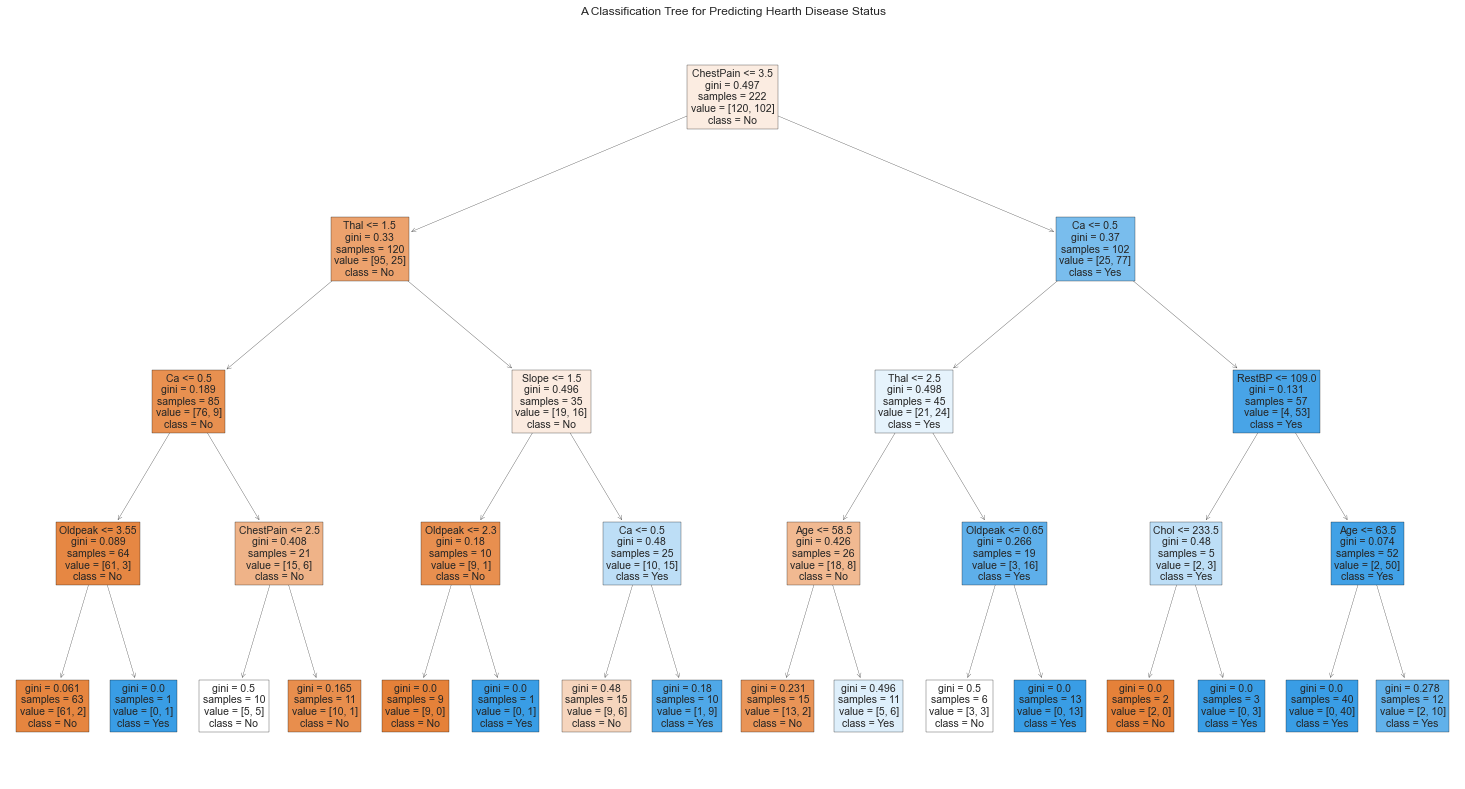

In [750]:
#visualize the tree
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [26, 14]

from sklearn.tree import plot_tree

fig, ax = plt.subplots()

tree_plot = plot_tree(d_tree, feature_names=X.columns, class_names=d_tree.classes_, impurity=True, ax=ax, filled=True)
plt.title("A Classification Tree for Predicting Hearth Disease Status")
plt.show();

Decision trees can be constructed even in the presence of **categorical features**.  For instance, the root node corresponds to splitting the categorical feature `ChestPain` (Chest pain type (1 = typical, 2 = nontypical, 3 = nonanginal, 4 = asymptomatic), and the first internal on the left corresponds to splitting the categorical feature `Tal` (Thalassemia (1 = normal, 2 = fixed defect, 3 = reversible defect).

<!--
![](img/week10_features.png)
-->

Let's calculate the accuracy of decision tree classifier built on train and test sets, respectively.

In [751]:
print("Train Accuracy: %.2f %%" % (d_tree.score(X_trainbig, y_trainbig)*100))
print("Test Accuracy: %.2f %%" % (d_tree.score(X_test, y_test)*100))

Train Accuracy: 87.84 %
Test Accuracy: 82.67 %


The accuracy scores on train and test sets reveal that there is an **over-fitting problem**. How to avoid it?

## Over-fitting in Decision Trees

* If a decision tree is allowed to train to its full strength, the model will likely to **over-fit** the data. 
* We can see that **increasing** the **number of maximum depth** and **maximum number of leaf nodes** leads to **over-fitting** since we are building a **larger tree**. 
* We can also see that **decreasing** the **minimum number of samples** required to split an internal node and the **minimum number of samples required to be at a leaf node** leads to over-fitting since we are forcing the tree learn from a small number of samples (memorize those points).
* `Small decision trees` are `less` prone to `over-fitting`.

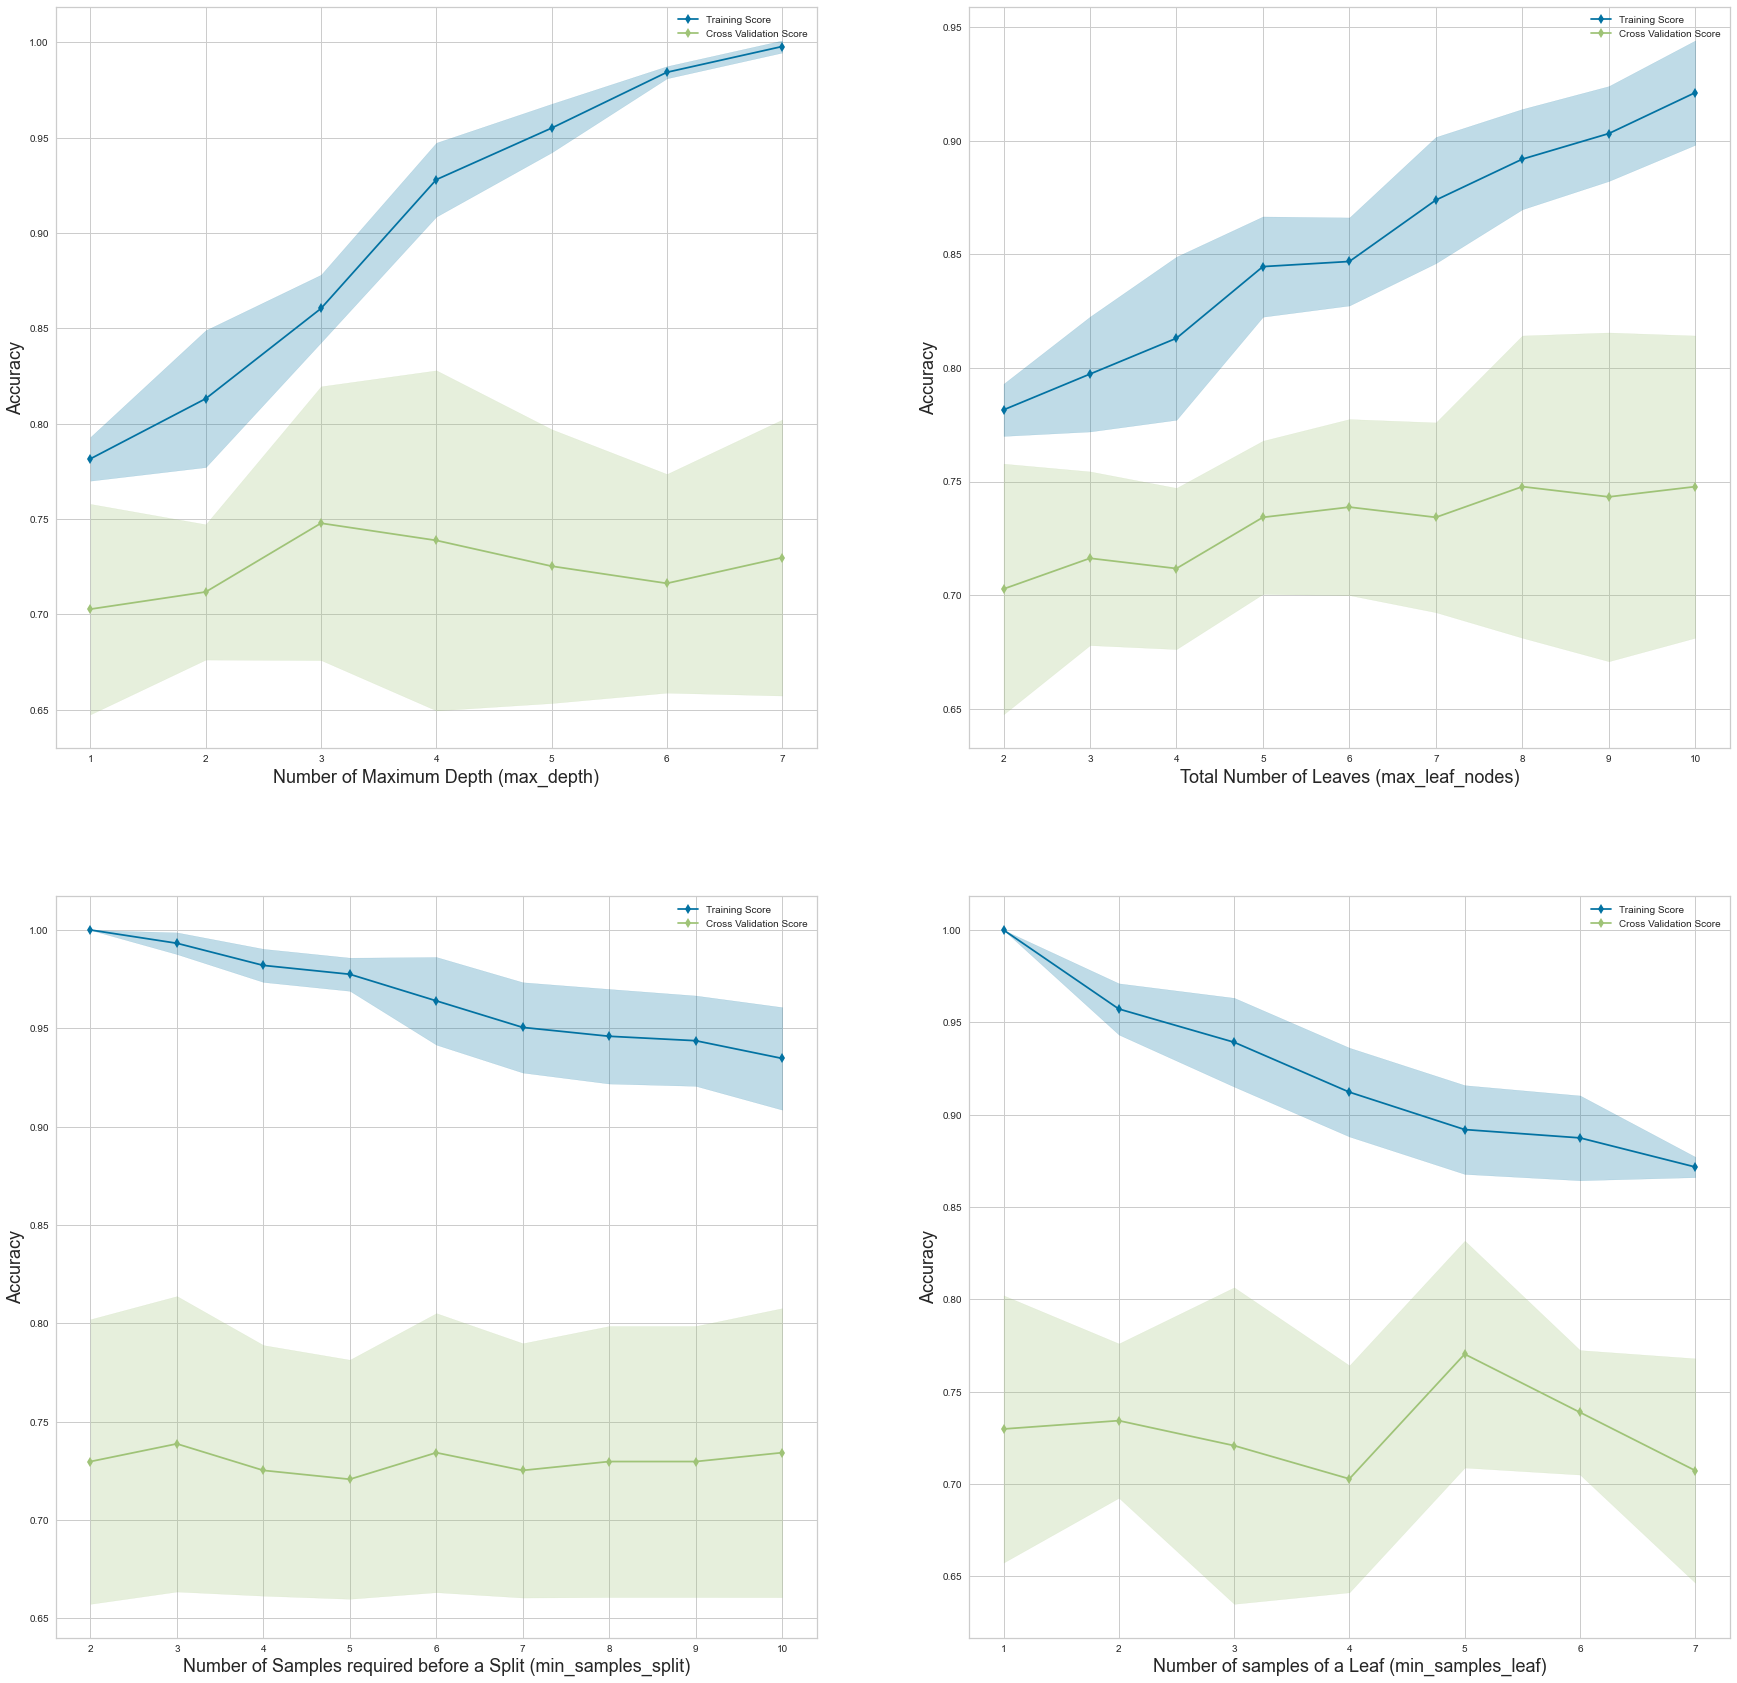

In [752]:
#visualize results
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 30]

from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.model_selection import ValidationCurve

tree = DecisionTreeClassifier(random_state=1773)

kcv_index = StratifiedKFold(n_splits=3, shuffle=True, random_state=1773)    

param_names = ["max_depth", "max_leaf_nodes", "min_samples_split", "min_samples_leaf"] 

param_ranges = [list(range(1, 8)), list(range(2, 11)),list(range(2, 11)), list(range(1, 8))]   

title=["Number of Maximum Depth (max_depth)", 
       "Total Number of Leaves (max_leaf_nodes)", 
       "Number of Samples required before a Split (min_samples_split)",
       "Number of samples of a Leaf (min_samples_leaf)"]


## Create figure space

fig, axis = plt.subplots(2,2)

for i, ax in enumerate(axis.reshape(-1), 0):
    
    #print(i)
    
    # Initialize figure object
    visualizer = ValidationCurve(estimator = tree, 
                                 param_name = param_names[i],  
                                 param_range = param_ranges[i], 
                                 cv = kcv_index, 
                                 scoring = "accuracy", 
                                 ax = ax)

    # Visualize
    visualizer.fit(X_trainbig, y_trainbig)
    visualizer.ax.set_ylabel("Accuracy", fontsize=18)
    visualizer.ax.set_xlabel(title[i], fontsize=18)
    visualizer.ax.legend().set_visible(True);

## Pre-Pruning

* `Pruning` refers to a technique to remove the parts of a decision tree to prevent growing its full depth. 

* `Pre-pruning` technique refers to the `early stopping` of the **growth of the decision tree**. 

* The pre-pruning technique involves tuning the hyper-parameters of the decision tree model including `max_depth`, `max_leaf_nodes`, `min_samples_split`, and `min_samples_leaf` prior to training the model so that we prevent it from over-fitting.

## Hyper-Parameter Tuning with RandomizedSearchCV

When tuning **multiple hyper-parameters**, [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) can take too much time. In such a case, [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) comes as an alternative to [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). 

[RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) works in the same way as [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), but instead of trying all possible hyper-parameter combinations, it tries a **random subset of combinations** to find the best combinations in a **limited time**.

Let's tune `max_depth`, `max_leaf_nodes`, `min_samples_split`, and `min_samples_leaf` hyper-parameters to find the best model.

In [753]:
#multiple hyper-parameter tuning with RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1773)

#defining parameter range
param_grid = {'max_depth': list(range(1, 5)),
              'max_leaf_nodes': list(range(1, 6)),
              'min_samples_split': list(range(2, 5)),
               'min_samples_leaf': list(range(4, 8)),
              }

#The folds are made by preserving the percentage of samples for each class.
kcv_index = StratifiedKFold(n_splits=3, shuffle=True, random_state=1773) 

rd_search = RandomizedSearchCV(estimator = tree, 
                               param_distributions = param_grid,  #only this argument name is different
                               scoring='accuracy', 
                               cv = kcv_index,
                               random_state=1773) #randomized

In [754]:
# fitting the model for randomized search cv
rd_search.fit(X_trainbig, y_trainbig)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1773, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=1773),
                   param_distributions={'max_depth': [1, 2, 3, 4],
                                        'max_leaf_nodes': [1, 2, 3, 4, 5],
                                        'min_samples_leaf': [4, 5, 6, 7],
                                        'min_samples_split': [2, 3, 4]},
                   random_state=1773, scoring='accuracy')

In [755]:
#best DecisionTreeClassifier on validation
rd_search.best_estimator_

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=4, min_samples_leaf=6,
                       min_samples_split=4, random_state=1773)

In [756]:
#Evaluate performance of best DecisionTreeClassifier on trainbig
print("Accuracy on trainbig data: %.2f %%" % (rd_search.best_estimator_.score(X_trainbig, y_trainbig)*100))

Accuracy on trainbig data: 81.98 %


In [757]:
#Evaluate performance of best DecisionTreeClassifier on test
print("Accuracy on test data: %.2f %%" % (rd_search.best_estimator_.score(X_test, y_test)*100))

Accuracy on test data: 82.67 %


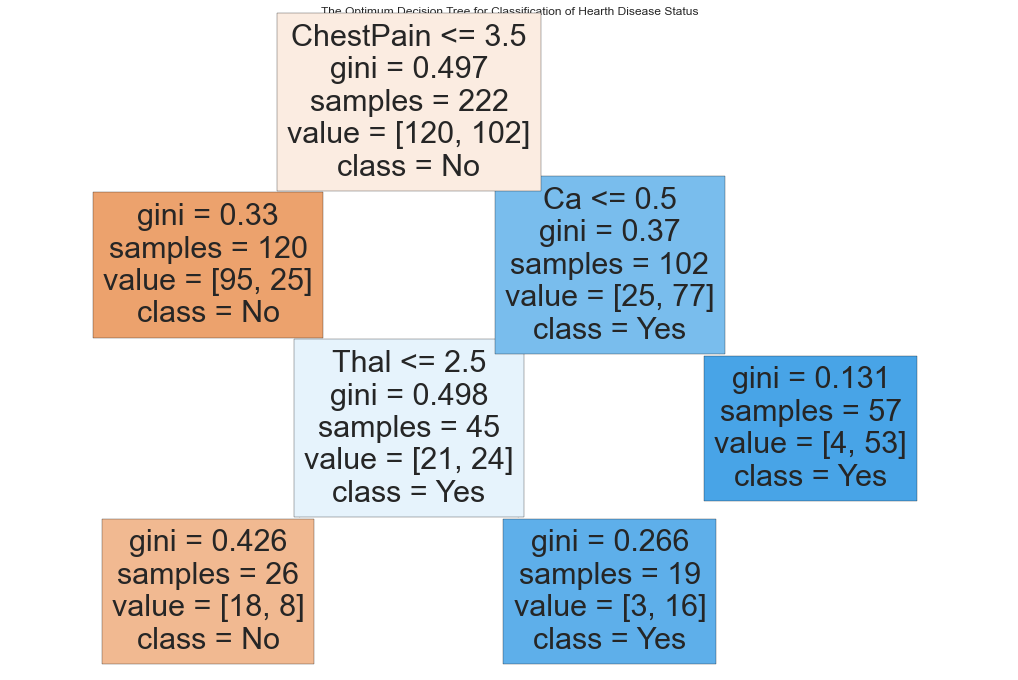

In [758]:
#visualize the  pruned tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]

from sklearn.tree import plot_tree

fig, ax = plt.subplots()

tree_plot = plot_tree(rd_search.best_estimator_, 
                      feature_names=X_trainbig.columns,  
                      class_names=rd_search.best_estimator_.classes_, 
                      impurity=True, ax=ax, filled=True)

plt.title("The Optimum Decision Tree for Classification of Hearth Disease Status")
plt.show();

## Feature Importance

Feature importance calculates the **mean impurity reduction** achieved by splitting on that feature. Feature importance score is changing between `0 and 1`. The `higher` the score, the `better` the feature contributes to the model. We can calculate the importance of each feature through the `feature_importances_` attribute in scikit-learn. 

The feature importance scores below show us that the **most important feature** to predict the heart disease status is the `ChestPain` value. For mathametics of how to calculate feature importance of each feature, please take a look at [here](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3#:~:text=Feature%20importance%20is%20calculated%20as,the%20more%20important%20the%20feature).

In [759]:
print(rd_search.best_estimator_.feature_names_in_)
print(rd_search.best_estimator_.feature_importances_)

['Age' 'Sex' 'ChestPain' 'RestBP' 'Chol' 'Fbs' 'RestECG' 'MaxHR' 'ExAng'
 'Oldpeak' 'Slope' 'Ca' 'Thal']
[0.         0.         0.69912326 0.         0.         0.
 0.         0.         0.         0.         0.         0.16779935
 0.1330774 ]


Alternatively, we can use [FeatureImportances](https://www.scikit-yb.org/en/latest/api/model_selection/importances.html) function from model selection module of `Yellowbrick` library to illustrate feature importance.

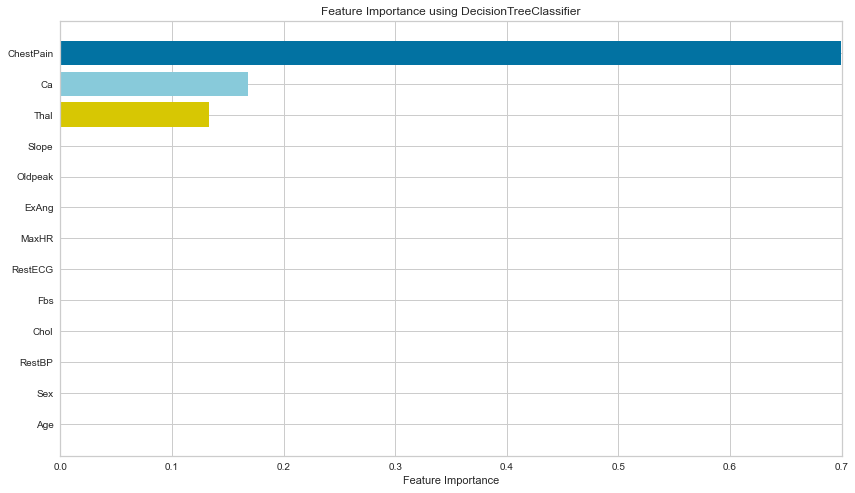

In [760]:
#throws warning: column names
import warnings
warnings.filterwarnings("ignore")

#visualize the importance of features
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]

from yellowbrick.model_selection import FeatureImportances

fig, ax = plt.subplots()

viz = FeatureImportances(rd_search.best_estimator_, relative=False, ax = ax) #
viz.fit(X_trainbig, y_trainbig)
viz.ax.set_xlim((0,0.7))
viz.ax.set_title("Feature Importance using DecisionTreeClassifier")
viz.ax.set_xlabel("Feature Importance")
plt.show();

The figure above shows the features ranked according to the importance for predicting the heart disease. 

Note that built classifier **does not use** the features except `ChestPain`,  `Ca`, and `Thal` to classify the heart disease status of the patients. We may want to exclude those features from our model.

Our model predicts if a patient has a heart disease with 82.67% accuracy using `ChestPain`,  `Ca`, and `Thal` as the most important characteristics.

## Pros and Cons of Decision Trees

Decision trees are important models in machine learning:
* They are **highly interpretable** with the help of visualizations.
* Require **little data preparation** (no rescaling, handle continuous and categorical features).

Their main disadvantages are that:
* If they stay small and interpretable, they are not as powerful.
* If they are large, they easily overfit.
* The small variation (or variance) in data can result in the different decision tree. This can be reduced by bagging and boosting algorithms.

## RandomForest Classifier Implementation

RandomForest Classifier is implemented in [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class of scikit-learn. The main parameters of the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) function are:

 * `n_estimators`: The number of trees in the forest.   
 * `max_depth`: Defines the depth of the tree, determined by the number of times splits are made. (limit it to a smaller number to prevent over-fitting)
 * `max_features`: The number of features to consider when looking for the best split (limit it to a smaller number to prevent over-fitting).
 
We will train a randomforest classifier using the `heart disease` dataset. 

In [761]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, criterion="gini", max_depth=3,  max_features='sqrt', random_state=1773)  #max_depth=3 for easiness

rf.fit(X_trainbig, y_trainbig)

print(rf)

RandomForestClassifier(max_depth=3, n_estimators=50, random_state=1773)


In [762]:
# The collection of fitted sub-estimators.
#rf.estimators_

Let's visualize some of the fitted sub-trees with changing the index value of `rf.estimators_` attribute each time.

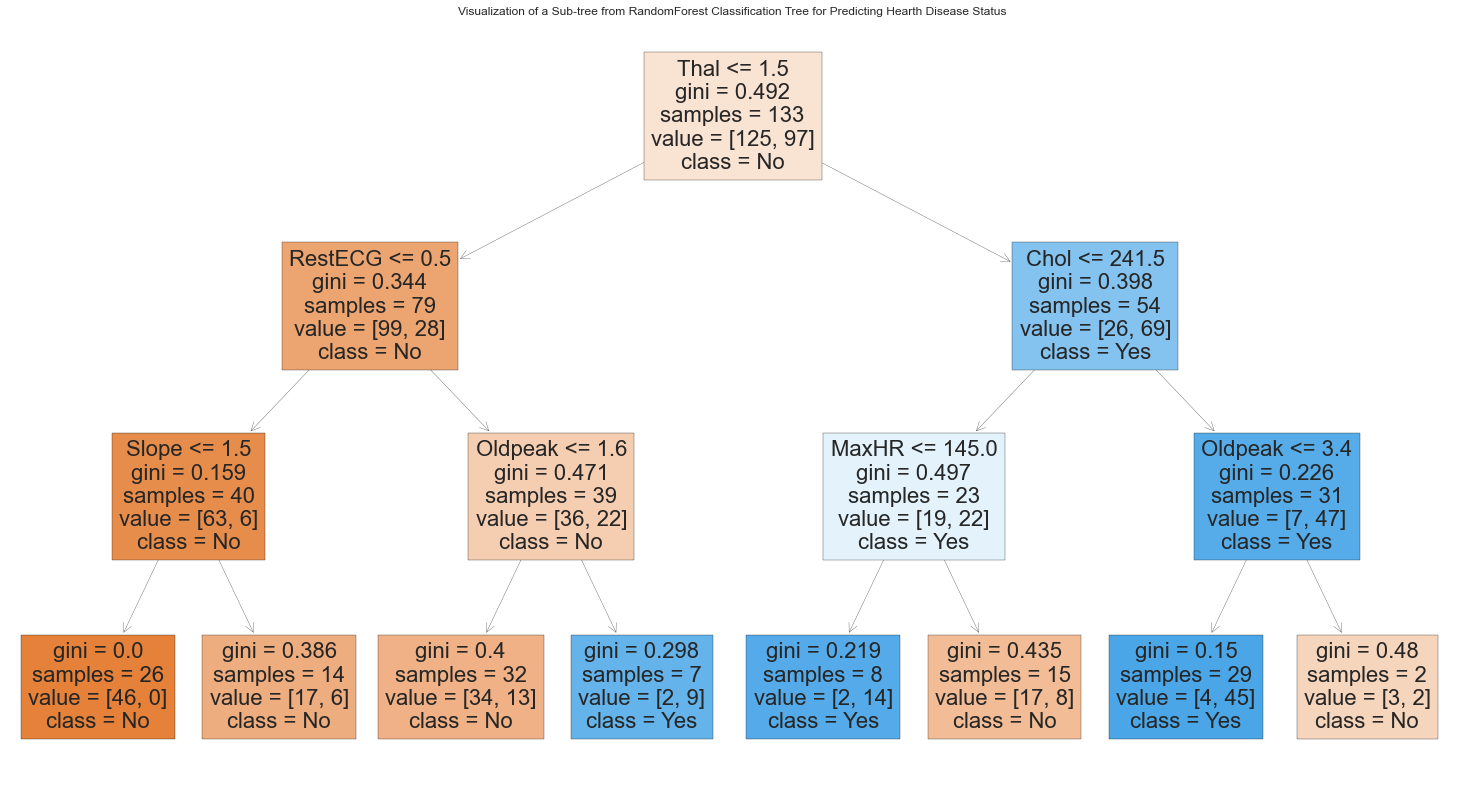

In [763]:
#visualize the sub-tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [26, 14]

from sklearn.tree import plot_tree

fig, ax = plt.subplots()

tree_plot = plot_tree(rf.estimators_[2], feature_names=X.columns, class_names=rf.classes_, impurity=True, ax=ax, filled=True)
plt.title("Visualization of a Sub-tree from RandomForest Classification Tree for Predicting Hearth Disease Status")
plt.show();

Let's calculate the accuracy of random forest classifier built on train and test sets, respectively. We can see that our random forest classifier does a better job on test data without tuning any hyper-parameter.

In [764]:
print("Train Accuracy: %.2f %%" % (rf.score(X_trainbig, y_trainbig)*100))
print("Test Accuracy: %.2f %%" % (rf.score(X_test, y_test)*100))

Train Accuracy: 87.39 %
Test Accuracy: 85.33 %


## Hyper-Parameter Tuning with RandomizedSearchCV

We can adjust `n_estimators`, `max_depth`, and `max_features`  and  search for best `n_estimators`, `max_depth`, and `max_features` combination through `RandomizedSearchCV` as we did for the single decision tree. However, often the default parameters of the random forest already work quite well.

## Feature Importance

Similar to decision trees, the random foret provides `feature importances`, which are computed by **aggregating the feature importance over the trees in the forest**. Typically, the feature importance provided by the random forest are more reliable than the ones provided by a single tree.

In [765]:
print(rf.feature_names_in_)
print(rf.feature_importances_)

['Age' 'Sex' 'ChestPain' 'RestBP' 'Chol' 'Fbs' 'RestECG' 'MaxHR' 'ExAng'
 'Oldpeak' 'Slope' 'Ca' 'Thal']
[0.04693852 0.03111531 0.18664069 0.02558519 0.02252647 0.00046148
 0.01672894 0.12563862 0.05111664 0.10792606 0.06021419 0.17556967
 0.14953822]


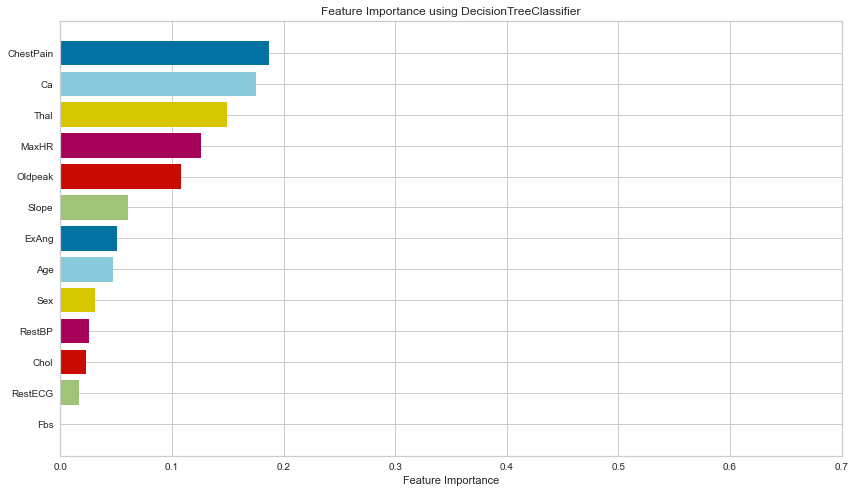

In [766]:
#throws warning: column names
import warnings
warnings.filterwarnings("ignore")

#visualize the importance of features
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]

from yellowbrick.model_selection import FeatureImportances

fig, ax = plt.subplots()

viz = FeatureImportances(rf, relative=False, ax = ax) #
viz.fit(X_trainbig, y_trainbig)
viz.ax.set_xlim((0,0.7))
viz.ax.set_title("Feature Importance using DecisionTreeClassifier")
viz.ax.set_xlabel("Feature Importance")
plt.show();

`Thal` is the most important feature now. Furthermore, as you can see, the random forest gives **non-zero importance** to many more features than the single tree to classify the heart disease.

## References

- James, G., Witten, D., Hastie, T., Tibshirani, R., James, G., Witten, D., and Tibshirani, R. (2021). Statistical learning. An introduction to statistical learning: with applications in R. https://www.statlearning.com/.
- Müller, A. C., and Guido, S. (2016). Introduction to machine learning with Python: A guide for data scientists. O'Reilly Media, Inc.
- Fan, J., Li, R., Zhang, C.H. and Zou, H., 2020. Statistical foundations of data science. CRC press.
- Wade, Corey, and Kevin Glynn. Hands-On Gradient Boosting with XGBoost and scikit-learn: Perform accessible machine learning and extreme gradient boosting with Python. Packt Publishing Ltd, 2020.
- https://github.com/kuleshov/cornell-cs5785-2020-applied-ml/tree/main/notebooks
- https://www.kaggle.com/code/arunmohan003/pruning-decision-trees-tutorial
- https://inria.github.io/scikit-learn-mooc/trees/trees_intuitions_index.html
- https://ubc-cs.github.io/cpsc330/lectures/02_decision-trees.html?highlight=decisiontreeclassifier
- https://towardsdatascience.com/3-techniques-to-avoid-overfitting-of-decision-trees-1e7d3d985a09
- https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084
- https://datascience.stackexchange.com/questions/66280/how-is-the-feature-importance-value-calculated-in-sklearn-random-forest-regre
- https://datascience.stackexchange.com/questions/57256/decision-trees-how-does-split-for-categorical-features-happen

In [767]:
import session_info
session_info.show()